In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
%matplotlib inline 

filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_Feb.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Na_Nap_Feb.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Mg_Mgp_Feb.nc"

filename2="Nc_Files/Jianfei_WACCMX_files/waccmx_T_Z3_e_Feb.nc"
#filename3="Nc_Files/Jianfei_WACCMX_files/waccmx_winds_Feb.nc"

M = filename[-10:]
Metal=M[0:2]
#print(Metal)

ds = xr.open_dataset(filename)
ds2 = xr.open_dataset(filename2)
#ds2
#ds

In [2]:
time = ds.variables['time']
times = xr.cftime_range(start="0001-02-01", periods=672, freq="1H", calendar="noleap")
times2 = ds["time"].dt.strftime("%Y%m%d %H:%M")

#timee = cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=None)

In [3]:
lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']

dst = ds.transpose("lev", ...)
Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']

In [4]:
ds2t = ds2.transpose("lev", ...)
temp = ds2t.variables['T']
elect = ds2t.variables['e']

geopH = ds2t.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))

#Mtdens = ( Mt * 1e-6 * 100 * lev ) / (1.380503e-23 * temp)
#Mptdens = ( Mpt * 1e-6 * 100 * lev ) / (1.380503e-23 * temp)


In [5]:
# Slice arrays (lev, altitude) between chosen range

lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

lev_sl_ind_min = lev[lev_sl_idx_min] 
lev_sl_ind_max = lev[lev_sl_idx_max] 
lev_sl_str = str("%.1e" % lev_sl_ind_min) + ' hPa : ' + str("%.1e" % lev_sl_ind_max) + ' hPa'
print('Plot lev = ' + lev_sl_str)


Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]

Zavg_sl_min = Zavg[lev_sl_idx_min] 
Zavg_sl_max = Zavg[lev_sl_idx_max]
Zavg_sl_str = str("%.0f" % Zavg_sl_min) + ' km : ' + str("%.0f" % Zavg_sl_max) + ' km'
print('Approx Z = ' + Zavg_sl_str)

geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

Plot lev = 1.5e-05 hPa : 6.0e-03 hPa
Approx Z = 128 km : 81 km


In [6]:
# Slice e density and temp by chosen alt range and time range (first 2 weeks of data)

electr = elect[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:]
tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:]

#electr #lev: 25 time: 672 lat: 96 lon: 144
#tempe #lev: 25 time: 672 lat: 96 lon: 144

In [7]:
# VMR to number density calculation

edens = ( electr * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
#edens #lev: 25 time: 336 lat: 96 lon: 144

In [8]:
# Create array with time info for each day 
day = np.arange(0,24)

# Create an array with offset needed for each UT time step (24h period)
# Offset by 15 degrees lon, lon axis is in 2.5 degree intervals
os =  day * 15 / 2.5 

offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable
for d in day:
    offset[d] = int(os[d]) #convert floats to ints to get integer number of indices to offset by
print(offset)

# Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
offset2 = np.reshape(offset2, (24*7))
offset3 = np.stack((offset2, offset2), axis=0)
offset3 = np.reshape(offset3, (168*2))
#offset3

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]


In [9]:
#Create edens_sh array so it has same dims etc as edens variable
#edens_sh = edens
#print(edens) #lev: 25 time: 336 lat: 96 lon: 144 

edens_sh = np.ndarray(edens.shape, dtype = float) 
#print(edens_sh.shape)   #(25, 336, 96, 144)


#Iterate over timear, offsetting e density at each time by 15 degrees lon
timear = np.arange(0,336)
for it in timear:
    edens_sh[:,it,:,:] = np.roll(edens[:,it,:,:], offset3[it] , axis=2)
    
#edens_sh.shape #(25, 336, 96, 144)

In [10]:
# Calculate average of offset e densities along time axis
edens_avg = np.mean(edens_sh,  axis=1)
#print(edens_avg.shape) #(25, 96, 144)

# Calculate std dev of offset e densities along time axis
edens_std = np.std(edens_sh, axis=1)
#edens_std.shape #(25, 96, 144)

In [11]:
# Set offset4 variable to reverse previous roll loop offset
offset4 = - offset3 

# Create edens_avg_roll & edens_std_roll arrays so they have same dims etc as edens variable
edens_avg_roll = np.ndarray(edens.shape, dtype = float) 
edens_std_roll = np.ndarray(edens.shape, dtype = float) 

# Iterate over timear, offsetting e density at each time by -15 degrees lon
for it in timear:
    edens_avg_roll[:,it,:,:] = np.roll(edens_avg[:,:,:], offset4[it] , axis=2)
    edens_std_roll[:,it,:,:] = np.roll(edens_std[:,:,:], offset4[it] , axis=2)

In [12]:
# Calculate difference between e density from model output and the average e density (rolling with time)
edens_diff = abs(edens-edens_avg_roll)

# Where the difference is less than set value of sigma, set to NaN
sigma_val = 1.5   #1sigma~68%   1.5sigma~87%    2sigma~95%
sigma_val_str = str(sigma_val)
SpEs = edens.where( edens_diff  > (sigma_val*edens_std_roll) )#, other=0 )

#Set string values for sigma symbol to use in plot
sigma_symb_str = 'sigma: \u03C3'
sigma = sigma_symb_str[-1]

In [45]:
#------------------------ Plot 1 setup: SpEs_plot-----------------------------

lev_sl_plot1_idx = 15   #15 #~94km      #23=82km low lim?
lev_sl_plot1 = lev_sl[lev_sl_plot1_idx]
lev_sl_plot1_str = str("%.1e" % lev_sl_plot1) + ' hPa'
print('Plot lev = ' + lev_sl_plot1_str)


Zavg_slplot1 = Zavg_sl[lev_sl_plot1_idx]
Zavg_sl_plot1_str = str("%.0f" % Zavg_slplot1) + ' km'
print('Approx Z = ' + Zavg_sl_plot1_str)

time_plot1_idx = 3  #3
time_plot1 = time[time_plot1_idx]

times_plot1 = times[time_plot1_idx]
times_plot1_str = str(times_plot1)
print('Plot time = ' + times_plot1_str)


Plot lev = 6.3e-04 hPa
Approx Z = 94 km
Plot time = 0001-02-01 03:00:00


In [46]:
edens_avg_plot = edens_avg[lev_sl_plot1_idx,:,:]

edens_plot = edens[lev_sl_plot1_idx,time_plot1_idx,:,:]
edens_sh_plot = edens_sh[lev_sl_plot1_idx,time_plot1_idx,:,:]
edens_avg_roll_plot = edens_avg_roll[lev_sl_plot1_idx,time_plot1_idx,:,:]
edens_std_roll_plot = edens_std_roll[lev_sl_plot1_idx,time_plot1_idx,:,:]

edens_diff_plot = edens_diff[lev_sl_plot1_idx,time_plot1_idx,:,:]
SpEs_plot = SpEs[lev_sl_plot1_idx,time_plot1_idx,:,:]
SpEs_plot = SpEs_plot / 1000

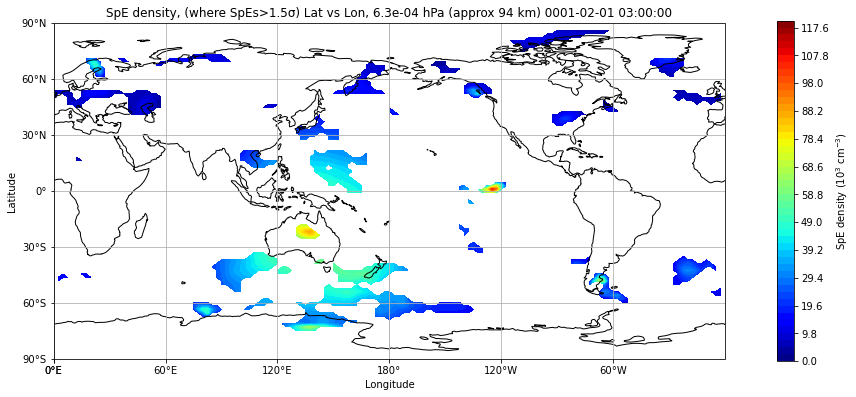

In [15]:
#------------------------ Plot 1.0: SpEs_plot -----------------------------

#ticks = np.linspace(min_edens,1e5,30)
#ticks = np.geomspace(min_edens,1e5,30)

ticks = np.linspace(0, 120)
#ticks = np.geomspace(0.1, 120)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, SpEs_plot, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('SpE density, (where SpEs>'  + sigma_val_str + sigma + ') Lat vs Lon, ' + 
             lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + ') ' + times_plot1_str )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.07,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#) #
#-------------------
#cbar = fig.colorbar(C)#,format='%.0e', fraction=0.023, pad=0.05)  #

cbar.set_label(r'SpE density (10$^{3}$ cm$^{-3}$)')

figname='SpEs: Lat vs Lon ' + 'SpEs gt'  + sigma_val_str + 'sigma ' + lev_sl_plot1_str + ' '+ times_plot1_str + '.png'
plt.savefig('./Figures/Jianfei_run/SpE_Identification/SpEs/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

In [16]:
# Define SpEs as based on relative diff from avg rather than absolute

percentage_diff = ( edens_diff / edens_avg_roll ) * 100. 

#percentage_lim = 87. #~1.5 sigma
percentage_lim = 68. #~1 sigma
#percentage_lim = 38. #~0.5 sigma
percentage_lim_str = str(percentage_lim)

SpEs_pd = edens.where( percentage_diff  > percentage_lim)# , other=0 )


In [17]:
# Define plot variables for global map plot

percentage_diff_plot = percentage_diff[lev_sl_plot1_idx,time_plot1_idx,:,:]

SpEs_pd_plot = SpEs_pd[lev_sl_plot1_idx,time_plot1_idx,:,:]
SpEs_pd_plot = SpEs_pd_plot / 1000

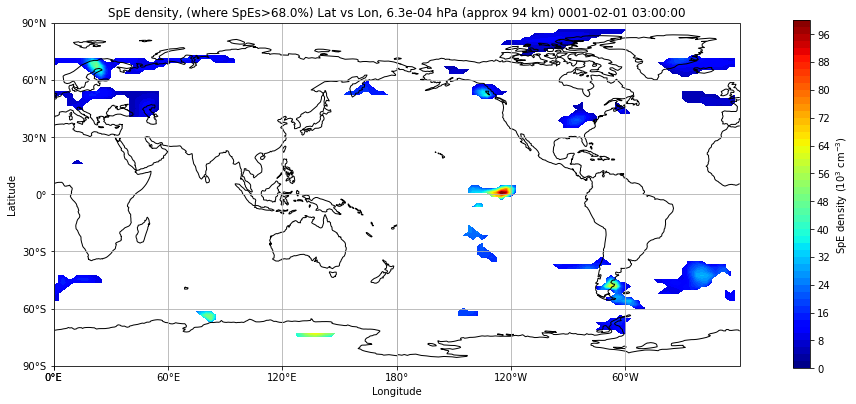

In [18]:
#------------------------ SpEs_pd_plot -----------------------------

#ticks = np.linspace(min_edens,1e5,30)
#ticks = np.geomspace(min_edens,1e5,30)

ticks = np.linspace(0, 100, 51)
#ticks = np.geomspace(0.1, 120)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, SpEs_pd_plot, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 #locator=ticker.LogLocator(),
                 #extend='max',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('SpE density, (where SpEs>'  + percentage_lim_str + '%) Lat vs Lon, ' + 
             lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + ') ' + times_plot1_str )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.07,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#) #
#-------------------
#cbar = fig.colorbar(C)#,format='%.0e', fraction=0.023, pad=0.05)  #

cbar.set_label(r'SpE density (10$^{3}$ cm$^{-3}$)')

figname='SpEs: Lat vs Lon ' + 'SpEs gt' + percentage_lim_str + '% ' + lev_sl_plot1_str + ' '+ times_plot1_str + '.png'
plt.savefig('./Figures/Jianfei_run/SpE_Identification/SpEs/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

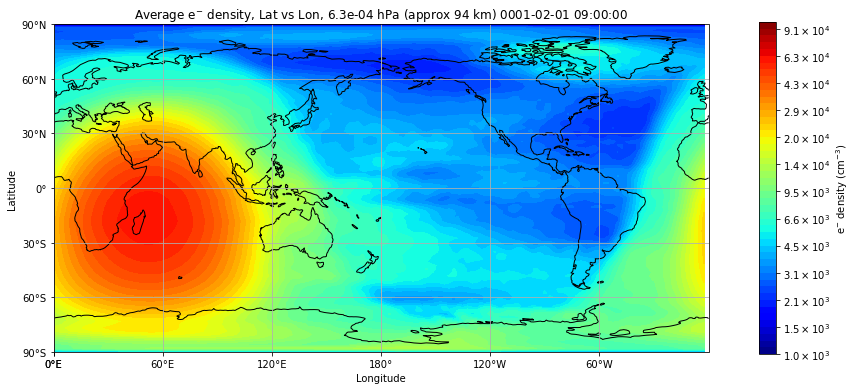

In [44]:
#------------------------ Plot 1.0: edens_avg_roll_plot -----------------------------

ticks = np.geomspace(1*10**3, 1*10**5)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, edens_avg_roll_plot, #edens_sh_plot,
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('Average e$^{-}$ density, Lat vs Lon, ' + 
             lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + ') ' + times_plot1_str )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#
#-------------------

cbar.set_label(r'e$^{-}$ density (cm$^{-3}$)')

figname='Avg e dens: Lat vs Lon ' + lev_sl_plot1_str + 'hPa '+ times_plot1_str + '.png'
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

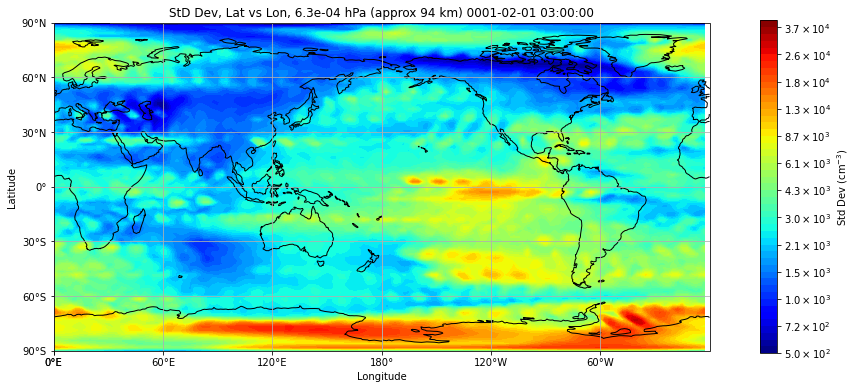

In [20]:
#------------------------Plot 1.0: edens_std_roll_plot -----------------------------

#ticks = np.linspace(min_edens,1e5,30)
#ticks = np.geomspace(min_edens,1e5,30)

ticks = np.geomspace(5*10**2, 4*10**4)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_global()

C = plt.contourf(lon, lat, edens_std_roll_plot, 
                 levels=ticks,
                 transform=ccrs.PlateCarree(),
                 locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.coastlines() 
ax.gridlines()

ax.set_xlabel('Longitude')

#ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())  
ax.set_ylabel('Latitude')
ax.set_title('StD Dev, Lat vs Lon, ' + 
             lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + ') ' + times_plot1_str )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, fraction=0.023, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#) #
#-------------------


cbar.set_label(r'Std Dev (cm$^{-3}$)')

figname='Std Dev: Lat vs Lon ' + lev_sl_plot1_str + 'hPa '+ times_plot1_str + '.png'
plt.savefig('./Figures/Jianfei_run/SpE_Identification/'+str(figname), dpi = 300) #
plt.tight_layout()
plt.show()

In [21]:
#-------------------Plot set up for plot 2: SpEs_plot2 -----------------------------
#--------------SpEs as a function of local time (one day in hrs) and altitude-------------------

#Location 1
#lat_plot2_idx = 36#(-21.8)
#lon_plot2_idx = 54#(135 lon)

#Location 2
#lat_plot2_idx = 37#(-19.9)     
#lon_plot2_idx = 87#(217.5) 

#Location 3
#lat_plot2_idx = 23#(-46.4)
#lon_plot2_idx = 117#(292.5)

#Location 4
#lat_plot2_idx = 8#(-74.8)   
#lon_plot2_idx = 54#(135 lon)

#Location 5
#lat_plot2_idx = 18#(-55.9)
#lon_plot2_idx = 62#(155 lon)


#Location 6
lat_plot2_idx = 49#(2.8)
lon_plot2_idx = 95#(237.5 lon)


#37#(-19.9)

#Location -
#lat_plot2_idx = 47 #(-0.9) 
#lon_plot2_idx = 132#(330)

In [22]:
#-------------------Plot set up for plot 2: SpEs_plot2 -----------------------------
#--------------SpEs as a function of local time (one day in hrs) and altitude-------------------

#Set plot time span to the first 24h period
tim_plot2_idx_min = 0
tim_plot2_idx_max = 24


lat_plot2_ind = lat[lat_plot2_idx] 
lat_plot2_str = str("%.1f" % lat_plot2_ind)
print('Plot lat = ' + lat_plot2_str)


lon_plot2_ind = lon[lon_plot2_idx] 
lon_plot2_str = str("%.1f" % lon_plot2_ind)
print('Plot lon = ' + lon_plot2_str)


tim_plot2_ind_min = times[tim_plot2_idx_min] 
tim_plot2_ind_max = times[tim_plot2_idx_max] 
tim_plot2_ind = times2[tim_plot2_idx_min:tim_plot2_idx_max+1] 

tim_plot2_str = str(tim_plot2_ind_min) + ' : ' + str(tim_plot2_ind_max)
print('Plot time = ' + tim_plot2_str)


geopH_slplot2 = geopH_sl[:,tim_plot2_idx_min:tim_plot2_idx_max+1,lat_plot2_idx,lon_plot2_idx]
#geopH_slplot2  #lev: 25 time: 25
geopH_slplot2 = geopH_slplot2.mean('time')
#geopH_slplot2  #lev: 25


#y_lims = [ lev_sl[-1], lev_sl[0] ] #Set y limits of plot to the min and max lev_sl


SpEs_plot2 = SpEs[:,tim_plot2_idx_min:tim_plot2_idx_max+1,lat_plot2_idx,lon_plot2_idx] 
SpEs_plot2 = SpEs_plot2 / 1000

Plot lat = 2.8
Plot lon = 237.5
Plot time = 0001-02-01 00:00:00 : 0001-02-02 00:00:00


In [23]:
#Sets up lev / alt axes

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

lowest_p = 1*10**-2
highest_p = 5*10**-6

low_ylim_idx = find_nearest(lev, lowest_p)
high_ylim_idx = find_nearest(lev, highest_p)

y_lims = [lev[low_ylim_idx], lev[high_ylim_idx]]


In [24]:
# Convert time into local time for the plot longitude

if lon_plot2_ind > 180.:
    lon_plot2 =  lon_plot2_ind - 360
else:
    lon_plot2 = lon_plot2_ind
 
print(lon_plot2)

timeconv = lon_plot2 / 15
timeconvr = timeconv.round()
timeconvrr = int(timeconvr)
print(timeconvrr)

timeticks = np.linspace( (0) , (24) ,25, dtype=int)
timeticks = np.linspace( (0+timeconvrr) , (24+timeconvrr) ,25, dtype=int)
print(timeticks)

timeticksar = np.arange(0,25,1)
for x in timeticksar:
    if timeticks[x] < 0:
        timeticks[x] = timeticks[x] + 24
#print(timeticks)

for x in timeticksar:
    if timeticks[x] >= 24:
        timeticks[x] = timeticks[x] - 24
print(timeticks)


<xarray.Variable ()>
array(-122.5)
-8
[-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16]
[16 17 18 19 20 21 22 23  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16]


/tmp/ipykernel_2791589/2867295300.py:37: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C,pad=0.12)#,format=ticker.FuncFormatter(fmt))


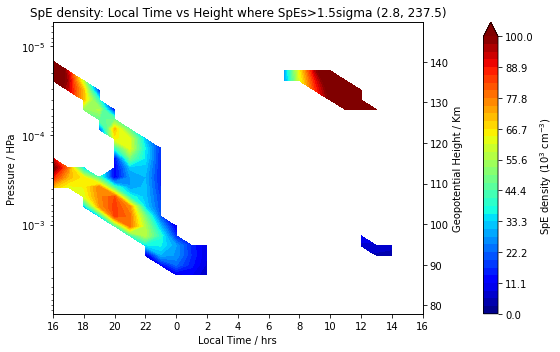

In [25]:
#------------------- Plot 2: SpEs_plot2 -----------------------------
#-------------SpE Local Time vs Height ------------------

#ticks = np.geomspace(0.1, 100, 37)
ticks = np.linspace(0, 100, 37)


fig, ax = plt.subplots(figsize=(8, 5))
C = ax.contourf(tim_plot2_ind, lev_sl, SpEs_plot2, 
                levels=ticks, 
                #locator=ticker.LogLocator(),
                extend='max',
                cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(y_lims[0], y_lims[1]) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13, dtype=int)) 
ax.set_xticklabels(timeticks[::2])

ax2 = ax.twinx()
ax2.set_ylabel('Geopotential Height / Km')
#ax2.set_ylim(Zavg_sl_max,Zavg_sl_min)

#ax2.set_ylim(geopH_slplot2[-1], geopH_slplot2[0]) #Used when basing left Pressure axis on sliced lev variable
ax2.set_ylim(Zavg[low_ylim_idx],Zavg[high_ylim_idx])


#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C,pad=0.12)#,format=ticker.FuncFormatter(fmt))
#-------------------


cbar.set_label(r'SpE density (10$^{3}$ cm$^{-3}$)')

plt.title('SpE density: Local Time vs Height ' + 'where SpEs>' + sigma_val_str + 'sigma' + ' (' + lat_plot2_str + ', ' + lon_plot2_str + ')' )
plt.tight_layout()

figname='SpEs: Local Time vs Height, SpEs gt'  + sigma_val_str + 'sigma (' +lat_plot2_str+ ', ' +lon_plot2_str+ ')' + '.png'
plt.savefig('./Figures/Jianfei_run/SpE_Identification/SpEs_time_height/'+str(figname), dpi = 300) #


In [26]:
SpEs_pd_plot2 = SpEs_pd[:,tim_plot2_idx_min:tim_plot2_idx_max+1,lat_plot2_idx,lon_plot2_idx] 
SpEs_pd_plot2 = SpEs_pd_plot2 / 1000

/tmp/ipykernel_2791589/1037445023.py:37: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C,pad=0.12)#,format=ticker.FuncFormatter(fmt))


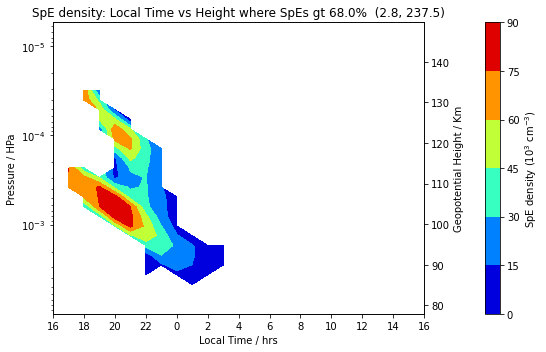

In [27]:
#------------------- Plot 2: SpEs_pd_plot2 -----------------------------
#-------------SpE Local Time vs Height ------------------

#ticks = np.geomspace(0.1, 100, 37)
#ticks = np.linspace(0, 100, 37)


fig, ax = plt.subplots(figsize=(8, 5))
C = ax.contourf(tim_plot2_ind, lev_sl, SpEs_pd_plot2, 
                #levels=ticks, 
                #locator=ticker.LogLocator(),
                #extend='max',
                cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(y_lims[0], y_lims[1]) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13, dtype=int)) 
ax.set_xticklabels(timeticks[::2])

ax2 = ax.twinx()
ax2.set_ylabel('Geopotential Height / Km')
#ax2.set_ylim(Zavg_sl_max,Zavg_sl_min)

#ax2.set_ylim(geopH_slplot2[-1], geopH_slplot2[0]) #Used when basing left Pressure axis on sliced lev variable
ax2.set_ylim(Zavg[low_ylim_idx],Zavg[high_ylim_idx])


#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C,pad=0.12)#,format=ticker.FuncFormatter(fmt))
#-------------------

#cbar = fig.colorbar(C,format='%.0e',pad=0.12)#,ticks=ticks2[::2], pad=0.05)

cbar.set_label(r'SpE density (10$^{3}$ cm$^{-3}$)')

plt.title('SpE density: Local Time vs Height ' + 'where SpEs gt ' + percentage_lim_str + '% ' + ' (' + lat_plot2_str + ', ' + lon_plot2_str + ')' )
plt.tight_layout()

figname='SpEs: Local Time vs Height,' + 'SpEs gt ' + percentage_lim_str + '% ' +lat_plot2_str+ ', ' +lon_plot2_str+ ')' + '.png'
plt.savefig('./Figures/Jianfei_run/SpE_Identification/SpEs_time_height/'+str(figname), dpi = 300) #


In [33]:
#-------------------Plot set up for plot 3:  -----------------------------
# "Slice at a particular latitude to see if the SpEs are in the E layer where they should be "

#Location 1
lat_plot3_idx = 36#(-21.8)

tim_plot3_idx = 0

In [34]:
SpEs_pd_plot3 = SpEs_pd[:,tim_plot3_idx,lat_plot3_idx,:] 
SpEs_pd_plot3 = SpEs_pd_plot3 / 1000

In [37]:
timeconv = lon / 15
timeconv

<xarray.Variable (lon: 144)>
array([ 0.        ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
        0.83333333,  1.        ,  1.16666667,  1.33333333,  1.5       ,
        1.66666667,  1.83333333,  2.        ,  2.16666667,  2.33333333,
        2.5       ,  2.66666667,  2.83333333,  3.        ,  3.16666667,
        3.33333333,  3.5       ,  3.66666667,  3.83333333,  4.        ,
        4.16666667,  4.33333333,  4.5       ,  4.66666667,  4.83333333,
        5.        ,  5.16666667,  5.33333333,  5.5       ,  5.66666667,
        5.83333333,  6.        ,  6.16666667,  6.33333333,  6.5       ,
        6.66666667,  6.83333333,  7.        ,  7.16666667,  7.33333333,
        7.5       ,  7.66666667,  7.83333333,  8.        ,  8.16666667,
        8.33333333,  8.5       ,  8.66666667,  8.83333333,  9.        ,
        9.16666667,  9.33333333,  9.5       ,  9.66666667,  9.83333333,
       10.        , 10.16666667, 10.33333333, 10.5       , 10.66666667,
       10.83333333, 11.        , 11.16666667, 11.33333333, 11.5       ,
       11.66666667, 11.83333333, 12.        , 12.16666667, 12.33333333,
       12.5       , 12.66666667, 12.83333333, 13.        , 13.16666667,
       13.33333333, 13.5       , 13.66666667, 13.83333333, 14.        ,
       14.16666667, 14.33333333, 14.5       , 14.66666667, 14.83333333,
       15.        , 15.16666667, 15.33333333, 15.5       , 15.66666667,
       15.83333333, 16.        , 16.16666667, 16.33333333, 16.5       ,
       16.66666667, 16.83333333, 17.        , 17.16666667, 17.33333333,
       17.5       , 17.66666667, 17.83333333, 18.        , 18.16666667,
       18.33333333, 18.5       , 18.66666667, 18.83333333, 19.        ,
       19.16666667, 19.33333333, 19.5       , 19.66666667, 19.83333333,
       20.        , 20.16666667, 20.33333333, 20.5       , 20.66666667,
       20.83333333, 21.        , 21.16666667, 21.33333333, 21.5       ,
       21.66666667, 21.83333333, 22.        , 22.16666667, 22.33333333,
       22.5       , 22.66666667, 22.83333333, 23.        , 23.16666667,
       23.33333333, 23.5       , 23.66666667, 23.83333333])

In [38]:
#Iterate over lon ar, calc LT from UT
lonar = np.arange(0,144)
LT = np.arange(0,144)

for ilon in lonar:
    LT[ilon] = timeconv[ilon]